# Imports and Setup

In [1]:
%cd ..

/Users/jason/repos/diffusion-motion-inbetweening


In [2]:
import warnings
from pathlib import Path

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from scipy.spatial.transform.rotation import Rotation as R

warnings.filterwarnings("once")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
from data_loaders.humanml.common import quaternion
from data_loaders.humanml.common.skeleton import Skeleton
from data_loaders.humanml.scripts.motion_process import recover_root_rot_pos
from data_loaders.humanml.utils import paramUtil
from utils import rotation_conversions

/Users/jason/repos/diffusion-motion-inbetweening/data_loaders/humanml/common/quaternion.py:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _FLOAT_EPS = np.finfo(np.float).eps


## Plotting

In [4]:
# @ipywidgets.interact(frame=(0, 195))
def plot_motion(
    samples_glb: np.ndarray,
    groundtruth_glb: np.ndarray,
    name: str,
    frame: int,
    show_ids=False,
    fixed_frames=[],
):
    fig = plt.figure(figsize=(9, 9))
    plt.suptitle(name)

    ax = fig.add_subplot(111, projection="3d")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")

    ax.view_init(elev=10, azim=25, vertical_axis="y")
    ax.axis("equal")

    ax.set_ylim(0, 2)
    ax.set_xlim(-1, 1)
    ax.set_zlim(-1, 1)

    for i in range(samples_glb.shape[0]):
        for chain in paramUtil.t2m_kinematic_chain:
            ax.plot3D(
                samples_glb[i, frame, chain, 0],
                samples_glb[i, frame, chain, 1],
                samples_glb[i, frame, chain, 2],
                color="red",
                alpha=0.5,
            )

    for chain in paramUtil.t2m_kinematic_chain:
        ax.plot3D(
            groundtruth_glb[frame, chain, 0],
            groundtruth_glb[frame, chain, 1],
            groundtruth_glb[frame, chain, 2],
            color="green",
            alpha=1 if frame in fixed_frames else 0.5,
        )

    if show_ids:
        for joint_id in range(groundtruth_glb.shape[1]):
            ax.text(
                groundtruth_glb[frame, joint_id, 0],
                groundtruth_glb[frame, joint_id, 1],
                groundtruth_glb[frame, joint_id, 2],
                f"{joint_id}",
                color="black",
                fontsize=8,
                alpha=0.5,
            )

    plt.show()

In [5]:
def plot_interactive(
    samples_glb: np.ndarray,
    groundtruth_glb: np.ndarray,
    name: str,
    show_ids=False,
    fixed_frames=[],
):
    @ipywidgets.interact(frame=(0, samples_glb.shape[1] - 1))
    def plot(frame):
        plot_motion(samples_glb, groundtruth_glb, name, frame, show_ids, fixed_frames)

    return plot

In [6]:
def plot_mask(name, feat_mask):
    plt.figure(figsize=(8, 6))
    plt.suptitle(name)
    sns.heatmap(feat_mask[:, 0, :], cmap="viridis", cbar=False)
    plt.xlabel("Frames")
    plt.ylabel("Joints")
    plt.tight_layout()
    plt.show()

# Restoring the animation from the rotation vector

1. **Input** the full HML3D feature vector `(n_rep, n_samples, n_frames, 263)`

2. **Extract** root position and joint quaternions from the feature vector `(n_rep, n_samples, n_frames, n_joints, 4)`

3. Apply **Forward Kinematics** to get the joint positions and plot

4. **Export** as BVH

## 1. Input Data

First we load the example skeleton to get the offset values for the joints
with which the dataset has been set up.

In [7]:
face_joint_indx = [2, 1, 17, 16]

example_data = np.load("dataset/000021.npy")
example_data = example_data.reshape(len(example_data), -1, 3)
example_data = torch.from_numpy(example_data)

tgt_skel = Skeleton(
    torch.from_numpy(paramUtil.t2m_raw_offsets), paramUtil.t2m_kinematic_chain, "cpu"
)
tgt_offsets = tgt_skel.get_offsets_joints(example_data[0])

In [8]:
tgt_offsets, tgt_offsets.shape

(tensor([[ 0.0000,  0.0000,  0.0000],
         [ 0.1031,  0.0000,  0.0000],
         [-0.1099,  0.0000,  0.0000],
         [ 0.0000,  0.1316,  0.0000],
         [ 0.0000, -0.3936,  0.0000],
         [ 0.0000, -0.3901,  0.0000],
         [ 0.0000,  0.1432,  0.0000],
         [ 0.0000, -0.4322,  0.0000],
         [ 0.0000, -0.4257,  0.0000],
         [ 0.0000,  0.0574,  0.0000],
         [ 0.0000,  0.0000,  0.1434],
         [ 0.0000,  0.0000,  0.1495],
         [ 0.0000,  0.2193,  0.0000],
         [ 0.1375,  0.0000,  0.0000],
         [-0.1434,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.1031],
         [ 0.0000, -0.1316,  0.0000],
         [ 0.0000, -0.1230,  0.0000],
         [ 0.0000, -0.2569,  0.0000],
         [ 0.0000, -0.2631,  0.0000],
         [ 0.0000, -0.2660,  0.0000],
         [ 0.0000, -0.2697,  0.0000]]),
 torch.Size([22, 3]))

In [9]:
results_path = Path(
    "save/results/condmdi_random_joints/condsamples000750000__benchmark_sparse_T=20_CI=0_CRG=0_KGP=1.0_seed10/results.npy"
    # "save/results/condmdi_random_joints/condsamples000750000__imputation_benchmark_clip_T=40_CI=0_CRG=0_KGP=1.0_seed10_person_throwing_a_ball/results.npy"

)
results = np.load(results_path, allow_pickle=True).item()

In [10]:
for k, v in results.items():
    print(k, v.shape if hasattr(v, "shape") else v)


sample (1, 10, 1, 196, 263)
motion (1, 10, 22, 3, 196)
text (10,)
lengths (1, 10)
num_samples 10
num_repetitions 1
observed_motion (10, 22, 3, 196)
observed_mask (10, 22, 1, 196)


In [11]:
rep_id = 0
sample_id = 6

# Frames where the root bone is observed/fixed
fixed_frames = np.argwhere(results["observed_mask"][sample_id, 0, 0, :] == 1).flatten()
fixed_frames

array([ 0, 20, 40, 60])

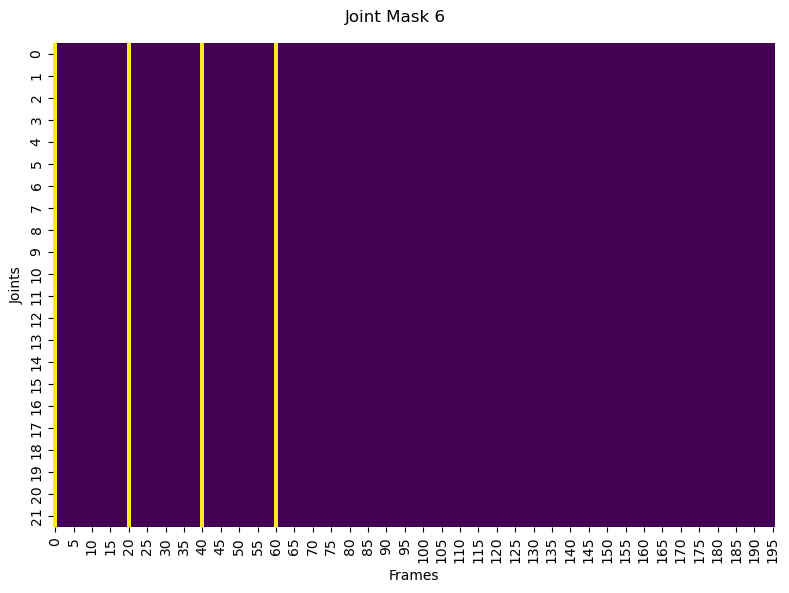

In [12]:
plot_mask(f"Joint Mask {sample_id}", results["observed_mask"][sample_id])


### Testing the `quaternion` module

In [13]:
for i in range(2):
    if i == 0:
        rot = R.from_matrix(torch.eye(3))
    else:
        rot = R.random()
    print("Matrix:")
    print(rot.as_matrix())
    print("")


    print("Matrix as Quat (scalar-first):")
    rotquat = rot.as_quat()[[3, 0, 1, 2]]
    print(rotquat)
    print("")

    print("Quat as Matrix:")
    print(quaternion.quaternion_to_matrix(torch.Tensor(rotquat)))
    print("")

    print("Quat as Cont6D:")
    # rot6d = rotation_conversions.matrix_to_rotation_6d(torch.Tensor(rot.as_matrix()))
    rotquat6d = quaternion.quaternion_to_cont6d(torch.Tensor(rotquat))
    # print(rot6d)
    print(rotquat6d)
    # print(torch.allclose(rot6d, rotquat6d, atol=1e-5))
    print("")

    print("Cont6D as Matrix:")
    rot6d_mat = quaternion.cont6d_to_matrix(rotquat6d)
    print(rot6d_mat)

    # Roundtrip using `quaternion.*`
    assert torch.allclose(rot6d_mat, torch.Tensor(rot.as_matrix()), atol=1e-5)

    print("\n----------------------------------------------------------------\n")


Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Matrix as Quat (scalar-first):
[1. 0. 0. 0.]

Quat as Matrix:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

Quat as Cont6D:
tensor([1., 0., 0., 0., 1., 0.])

Cont6D as Matrix:
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

----------------------------------------------------------------

Matrix:
[[ 0.36099743 -0.17190958 -0.91658494]
 [ 0.39837784 -0.86024192  0.31824351]
 [-0.8431939  -0.48003222 -0.24206015]]

Matrix as Quat (scalar-first):
[-0.25431052  0.7847451   0.07214708 -0.56062116]

Quat as Matrix:
tensor([[ 0.3610, -0.1719, -0.9166],
        [ 0.3984, -0.8602,  0.3182],
        [-0.8432, -0.4800, -0.2421]])

Quat as Cont6D:
tensor([ 0.3610,  0.3984, -0.8432, -0.1719, -0.8602, -0.4800])

Cont6D as Matrix:
tensor([[ 0.3610, -0.1719, -0.9166],
        [ 0.3984, -0.8602,  0.3182],
        [-0.8432, -0.4800, -0.2421]])

----------------------------------------------------------------



## Extract & IK from the original faulty rotation representation

In [59]:
def recover_pos_from_rot(
    data: torch.Tensor, joints_num: int, skeleton: Skeleton, abs_3d=False
):
    # Get root rotation and position
    r_rot_quat, r_pos = recover_root_rot_pos(data, abs_3d=abs_3d)
    r_rot_cont6d = quaternion.quaternion_to_cont6d(r_rot_quat)

    # Extract rotations from feature vector
    start_indx = 1 + 2 + 1 + (joints_num - 1) * 3
    end_indx = start_indx + (joints_num - 1) * 6
    cont6d_params = data[..., start_indx:end_indx]

    # Combine root and joint rotations
    cont6d_params = torch.cat([r_rot_cont6d, cont6d_params], dim=-1)
    cont6d_params = cont6d_params.view(-1, joints_num, 6)

    # Forward kinematics to get joint positions
    global_pos = skeleton.forward_kinematics_cont6d(cont6d_params, r_pos)

    #! If this renders properly, this means, the data comes from the original preprocessing

    return global_pos, cont6d_params


def recover_rot_from_pos(
    data: torch.Tensor, joints_num: int, skeleton: Skeleton, abs_3d=False, as_quat=False
):
    # Get root rotation and position
    r_rot_quat, r_pos = recover_root_rot_pos(data, abs_3d=abs_3d)

    # Extract joint positions from feature vector
    start_indx = 1 + 2 + 1
    end_indx = start_indx + (joints_num - 1) * 3
    positions = data[..., start_indx:end_indx]
    positions = positions.view(positions.shape[:-1] + (-1, 3))

    """Add Y-axis rotation to local joints"""
    positions = quaternion.qrot(
        quaternion.qinv(r_rot_quat[..., None, :]).expand(positions.shape[:-1] + (4,)),
        positions,
    )

    """Add root XZ to joints"""
    positions[..., 0] += r_pos[..., 0:1]
    positions[..., 2] += r_pos[..., 2:3]

    """Concate root and joints"""
    positions = torch.cat([r_pos.unsqueeze(-2), positions], dim=-2)[0]

    """Do the corrected IK to get the rotations"""
    quat_wxyz = skeleton.inverse_kinematics_quat_standard_np(
        positions.numpy(), face_joint_indx
    )
    quat_wxyz = torch.from_numpy(quat_wxyz).float()

    """Do the corrected FK to get back to positions"""
    new_positions = skeleton.forward_kinematics_quat_standard(
        quat_params=quat_wxyz, root_pos=r_pos
    )

    rotations = quaternion.quaternion_to_matrix(quat_wxyz)

    return new_positions, rotations, quat_wxyz

In [39]:
pos_from_rot, rot = recover_pos_from_rot(
    torch.from_numpy(results["sample"][rep_id, sample_id]),
    joints_num=22,
    skeleton=tgt_skel,
    abs_3d=True,
)
pos_from_rot = pos_from_rot.squeeze(-1)
print(pos_from_rot.shape, rot.shape)

pos, rot_from_pos, quat_from_pos = recover_rot_from_pos(
    torch.from_numpy(results["sample"][rep_id, sample_id]),
    joints_num=22,
    skeleton=tgt_skel,
    abs_3d=True,
)
print(pos.shape, rot_from_pos.shape, quat_from_pos.shape)

torch.Size([196, 22, 3]) torch.Size([196, 22, 3, 3])
torch.Size([196, 22, 3]) torch.Size([196, 22, 3, 3]) torch.Size([196, 22, 4])


In [40]:
torch.allclose(pos_from_rot, pos), torch.allclose(rot, rot_from_pos)

(False, False)

In [41]:

plot_interactive(
    samples_glb=pos_from_rot.numpy()[None, ...],
    groundtruth_glb=results["observed_motion"][sample_id].transpose(2, 0, 1),
    name="Pos Recovered from Rot",
    show_ids=False,
    fixed_frames=fixed_frames,
)


interactive(children=(IntSlider(value=97, description='frame', max=195), Output()), _dom_classes=('widget-inte…

<function __main__.plot_interactive.<locals>.plot(frame)>

In [42]:
pos_diff = pos_from_rot - pos
mean_pos_dist = pos_diff.norm(dim=-1).mean()
std_pos_dist = pos_diff.std(dim=-1).std()
print(f"Mean pos distance: {mean_pos_dist:.4f} +- {std_pos_dist:.4f}")

Mean pos distance: 0.2823 +- 0.1199


In [43]:
radian_diff = rotation_conversions.matrix_to_euler_angles(
    rot.transpose(-1, -2), "XYZ"
) - rotation_conversions.matrix_to_euler_angles(rot_from_pos.transpose(-1, -2), "XYZ")
mean_deg_diff = torch.rad2deg(radian_diff).norm(dim=-1).mean()
std_deg_diff = torch.rad2deg(radian_diff).std(dim=-1).std()
print(f"Mean rot difference in degrees: {mean_deg_diff:.4f} +- {std_deg_diff:.4f}")

Mean rot difference in degrees: 39.7917 +- 32.6950


In [44]:
plot_interactive(
    pos.numpy()[None, ...],
    results["observed_motion"][sample_id].transpose(2, 0, 1),
    "Recovered Pos",
    show_ids=False,
    fixed_frames=fixed_frames,
)

interactive(children=(IntSlider(value=97, description='frame', max=195), Output()), _dom_classes=('widget-inte…

<function __main__.plot_interactive.<locals>.plot(frame)>

In [45]:
from convert.joints2bvh import BVH, Animation
from convert.joints2bvh import BVH_custom as BVHc
from convert.joints2bvh.Quaternions import Quaternions


In [46]:
anim = BVH.load("convert/joints2bvh/data/template.bvh")

# These are literally the OFFSET values in the BVH
# aka the local joint positions relative to the parent joint
anim.offsets, anim.offsets.shape

(array([[-0.001795, -0.223333,  0.028219],
        [ 0.06952 , -0.091406, -0.006815],
        [ 0.034277, -0.375199, -0.004496],
        [-0.013596, -0.397961, -0.043693],
        [ 0.026358, -0.055791,  0.119288],
        [-0.06767 , -0.090522, -0.00432 ],
        [-0.03829 , -0.382569, -0.00885 ],
        [ 0.015774, -0.398415, -0.042312],
        [-0.025372, -0.048144,  0.123348],
        [-0.002533,  0.108963, -0.026696],
        [ 0.005487,  0.13518 ,  0.001092],
        [ 0.001457,  0.052922,  0.025425],
        [-0.002778,  0.21387 , -0.042857],
        [ 0.005152,  0.06497 ,  0.051349],
        [ 0.078845,  0.121749, -0.03409 ],
        [ 0.090977,  0.030469, -0.008868],
        [ 0.259612, -0.012772, -0.027456],
        [ 0.249234,  0.008986, -0.001171],
        [-0.081759,  0.118833, -0.038615],
        [-0.096012,  0.032551, -0.009143],
        [-0.253742, -0.013329, -0.021401],
        [-0.255298,  0.007772, -0.005559]]),
 (22, 3))

In [47]:
(trot, tpos, orients, toffsets, parents, names, tframetime) = BVHc.load("convert/joints2bvh/data/template.bvh")

In [48]:
def convert_to_bvh_using_skel_offsets(positions: torch.Tensor, rotations: torch.Tensor, offsets, filename=None):

    re_order = [0, 1, 4, 7, 10, 2, 5, 8, 11, 3, 6, 9, 12, 15, 13, 16, 18, 20, 14, 17, 19, 21]
    re_order_inv = [0, 1, 5, 9, 2, 6, 10, 3, 7, 11, 4, 8, 12, 14, 18, 13, 15, 19, 16, 20, 17, 21]

    (trot, tpos, orients, toffsets, parents, names, tframetime) = BVHc.load("convert/joints2bvh/data/template.bvh")

    # rotations_euler = torch.rad2deg(rotation_conversions.matrix_to_euler_angles(rotations, 'XYZ'))

    rotations_quat = []
    rotations_euler = []
    for i in range(rotations.shape[0]):
        rotation_conversions.matrix_to_euler_angles(rotations[i], 'XYZ')
        rotations_quat.append(R.from_matrix(rotations[i]).as_quat()[..., [3, 0, 1, 2]])
        rotations_euler.append(R.from_matrix(rotations[i]).as_euler('XYZ', degrees=True))
    rotations_quat = np.stack(rotations_quat)
    rotations_euler = np.stack(rotations_euler)

    BVHc.save(
        filename,
        parents,
        offsets[re_order],
        rotations_euler[:, re_order],
        positions[:, re_order],
        names,
        frametime=1 / 20,
        order='zyx'
    )



In [49]:
convert_to_bvh_using_skel_offsets(pos.numpy(), rot, tgt_offsets, "test.bvh")

---

---

---

### `Quat -> FK -> Pos -> IK -> Quat_out` --- `Quat_in != Quat_out` 

In [50]:
quat_in = quat_from_pos
mat_in = quaternion.quaternion_to_matrix(quat_in)
euler_in = rotation_conversions.matrix_to_euler_angles(mat_in, 'XYZ')
aa_in = rotation_conversions.quaternion_to_axis_angle(quat_in)

p = tgt_skel.forward_kinematics(quat_from_pos, pos[:, 0])
quat_out = torch.from_numpy(tgt_skel.inverse_kinematics_np(p.numpy(), face_joint_indx, fixed=True))
quat_out = quaternion.qnormalize(quat_out)

mat_out = quaternion.quaternion_to_matrix(quat_out)
euler_out = rotation_conversions.matrix_to_euler_angles(mat_out, 'XYZ')
aa_out = rotation_conversions.quaternion_to_axis_angle(quat_out)

In [51]:
torch.allclose(quat_in, quat_out.float(), atol=1e-2), \
    torch.allclose(mat_in, mat_out.float(), atol=1e-1)


(False, False)

Dont get confused by these, the positions still (almost) match!


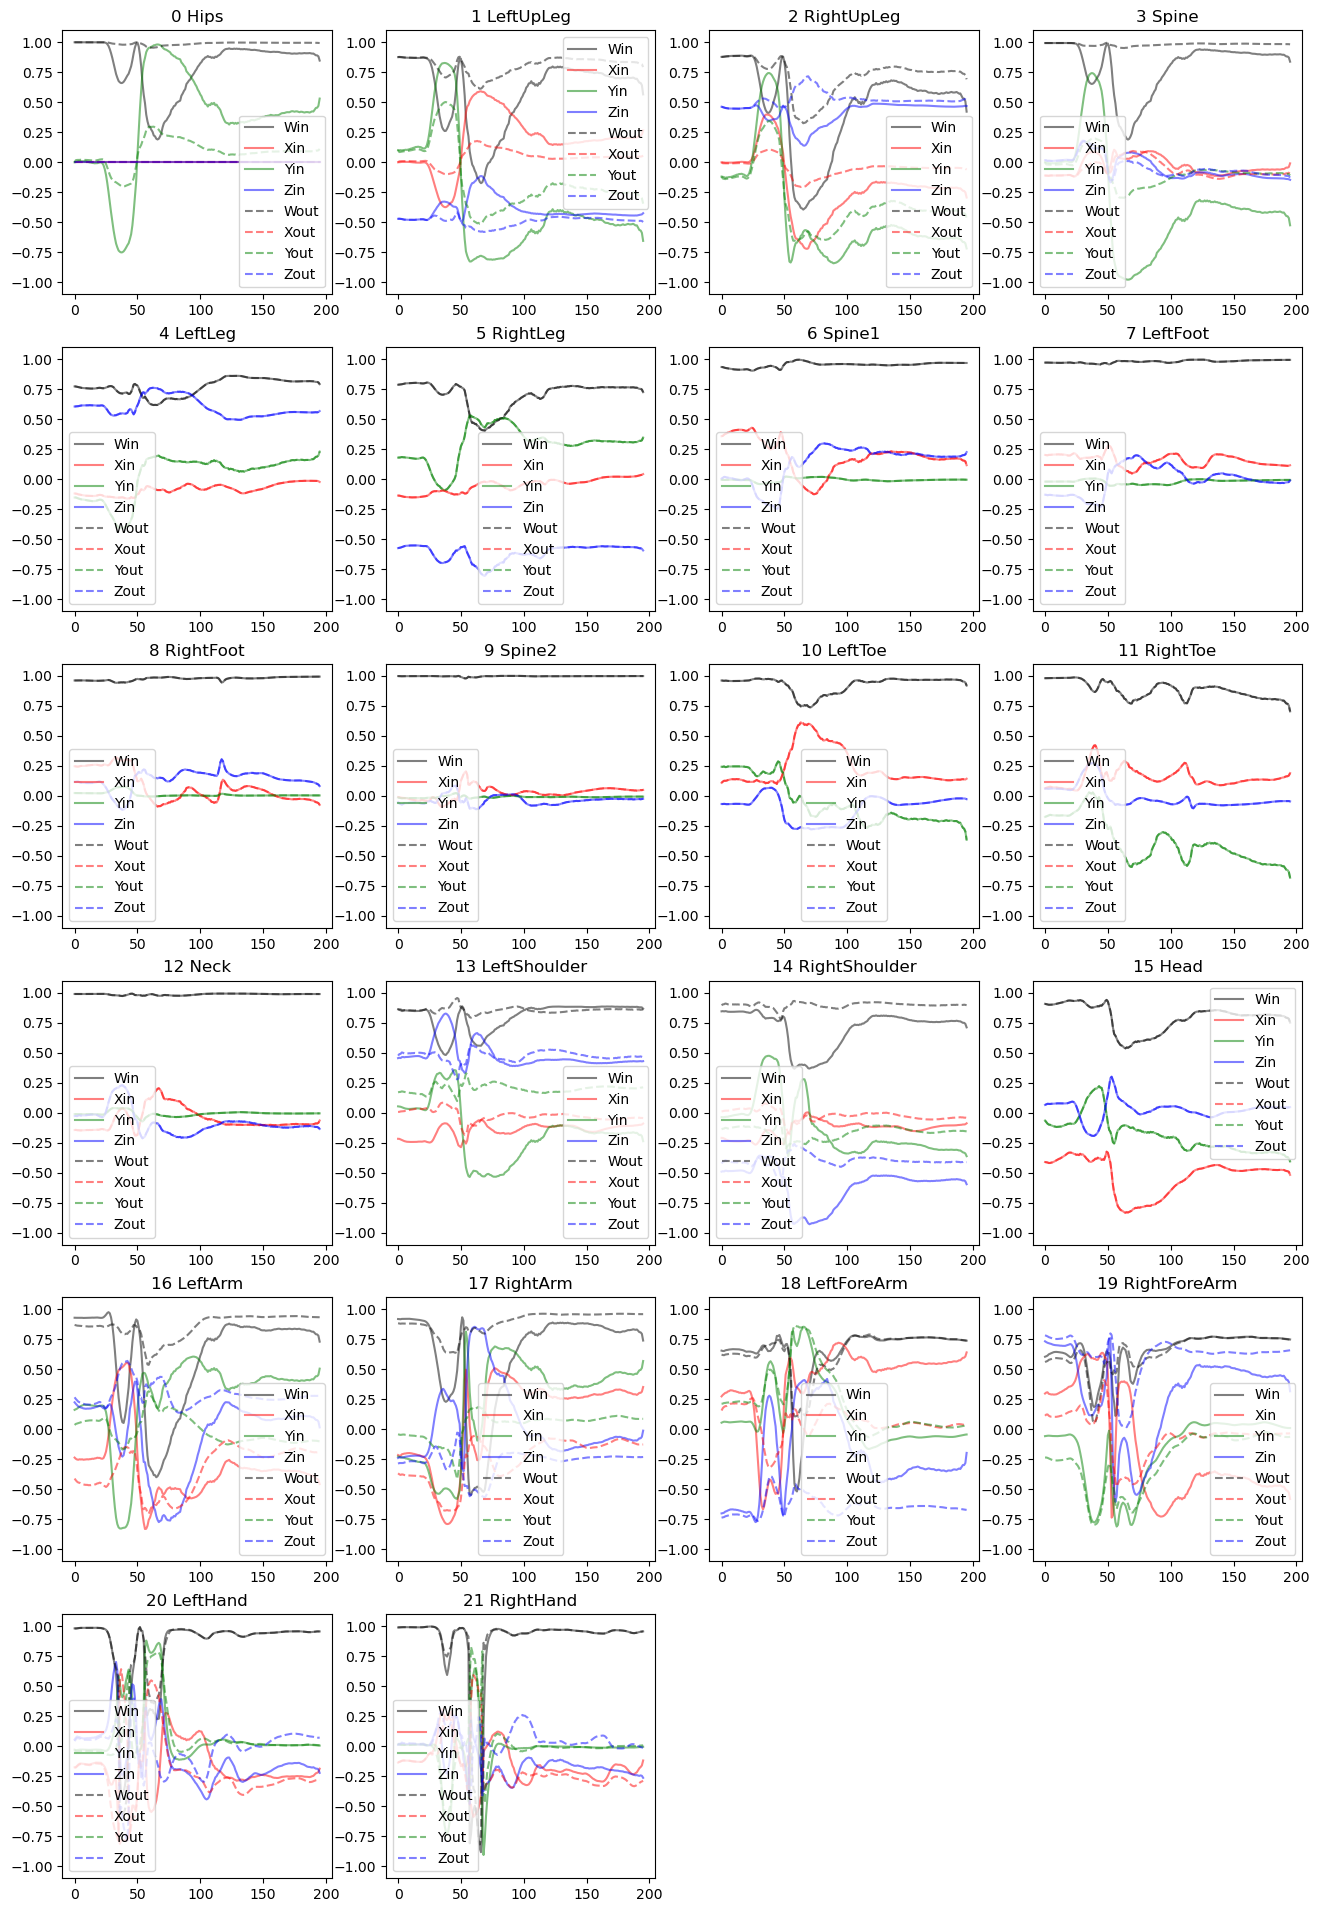

In [52]:
names_inv = [names[i] for i in [0, 1, 5, 9, 2, 6, 10, 3, 7, 11, 4, 8, 12, 14, 18, 13, 15, 19, 16, 20, 17, 21]]

print("Dont get confused by these, the positions still (almost) match!")

fig = plt.figure(figsize=(16, 24))
for j in range(22):
    plt.subplot(6, 4, j+1)
    plt.title(f"{j} {names_inv[j]}")
    plt.ylim(-1.1, 1.1)
    plt.plot(quat_in[:, j, 0], c="black", linestyle="-", label="Win", alpha=0.5)
    plt.plot(quat_in[:, j, 1], c="red", linestyle="-", label="Xin", alpha=0.5)
    plt.plot(quat_in[:, j, 2], c="green", linestyle="-", label="Yin", alpha=0.5)
    plt.plot(quat_in[:, j, 3], c="blue", linestyle="-", label="Zin", alpha=0.5)
    plt.plot(quat_out[:, j, 0], c="black", linestyle="--", label="Wout", alpha=0.5)
    plt.plot(quat_out[:, j, 1], c="red", linestyle="--", label="Xout", alpha=0.5)
    plt.plot(quat_out[:, j, 2], c="green", linestyle="--", label="Yout", alpha=0.5)
    plt.plot(quat_out[:, j, 3], c="blue", linestyle="--", label="Zout", alpha=0.5)
    plt.legend()

plt.show()


Dont get confused by these, the positions still (almost) match!


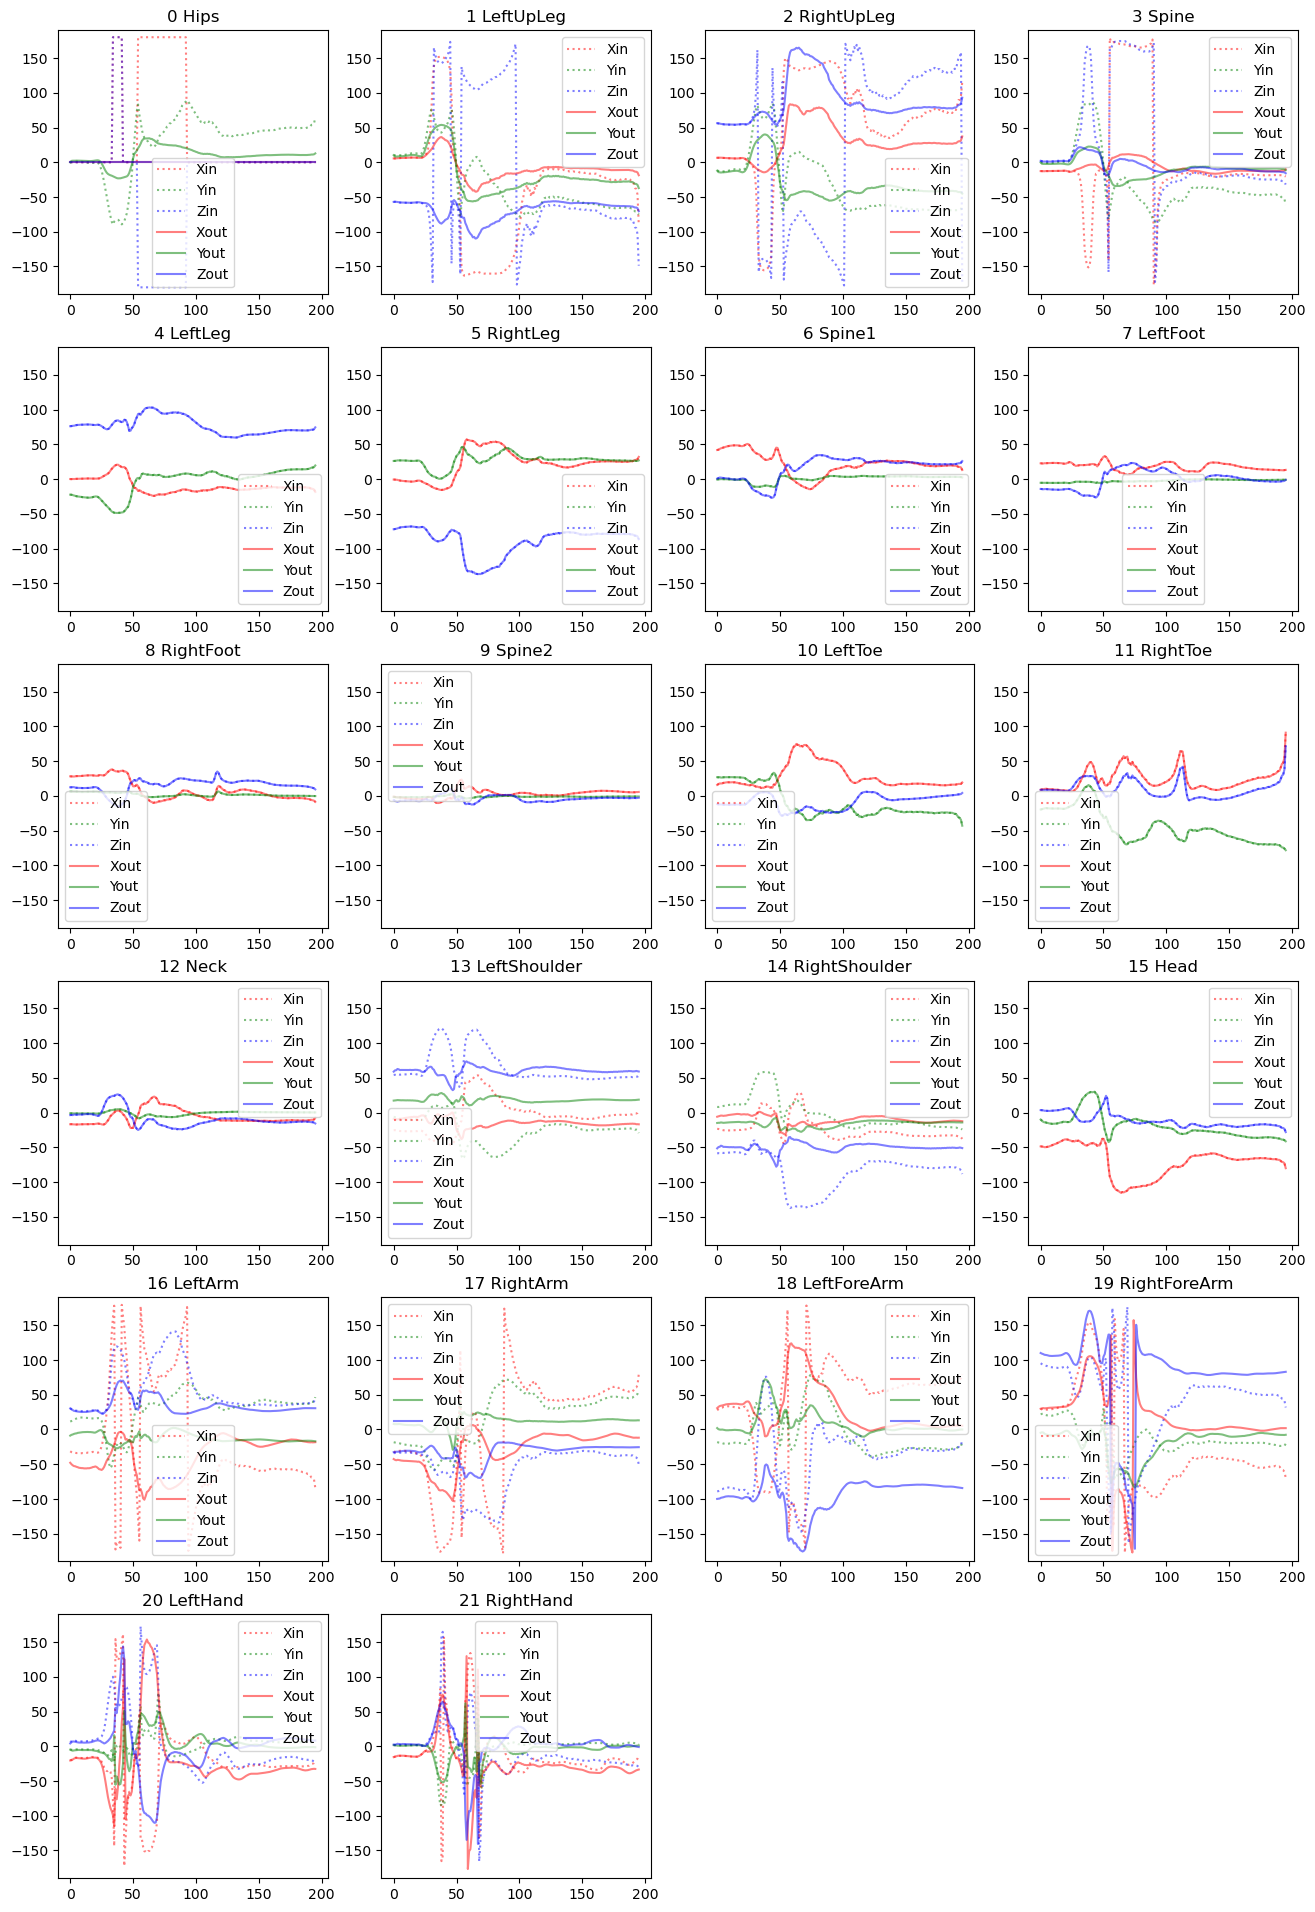

In [53]:
names_inv = [names[i] for i in [0, 1, 5, 9, 2, 6, 10, 3, 7, 11, 4, 8, 12, 14, 18, 13, 15, 19, 16, 20, 17, 21]]

print("Dont get confused by these, the positions still (almost) match!")

fig = plt.figure(figsize=(16, 24))
for j in range(22):
    plt.subplot(6, 4, j+1)
    plt.title(f"{j} {names_inv[j]}")
    plt.ylim(-190, 190)
    plt.plot(np.rad2deg(euler_in[:, j, 0]), c="red", linestyle=":", label="Xin", alpha=0.5)
    plt.plot(np.rad2deg(euler_in[:, j, 1]), c="green", linestyle=":", label="Yin", alpha=0.5)
    plt.plot(np.rad2deg(euler_in[:, j, 2]), c="blue", linestyle=":", label="Zin", alpha=0.5)
    plt.plot(np.rad2deg(euler_out[:, j, 0]), c="red", linestyle="-", label="Xout", alpha=0.5)
    plt.plot(np.rad2deg(euler_out[:, j, 1]), c="green", linestyle="-", label="Yout", alpha=0.5)
    plt.plot(np.rad2deg(euler_out[:, j, 2]), c="blue", linestyle="-", label="Zout", alpha=0.5)
    plt.legend()

plt.show()


### `Pos_in -> IK -> Quat -> FK -> Pos_out` --- `pos_in ~~ pos_out` 

In [54]:
pos_in = pos.numpy()
q = tgt_skel.inverse_kinematics_np(pos_in, face_joint_indx, fixed=True)
pos_out = tgt_skel.forward_kinematics_np(q, pos[:, 0])

In [55]:
diff = np.linalg.norm(pos_in - pos_out, axis=-1)
diff.mean(), diff.std()

(0.048315749856190575, 0.0795279174273244)

In [56]:
plot_interactive(
    pos_out[None, ...],
    results["observed_motion"][sample_id].transpose(2, 0, 1),
    "Recovered Pos",
    show_ids=False,
    fixed_frames=fixed_frames,
)

interactive(children=(IntSlider(value=97, description='frame', max=195), Output()), _dom_classes=('widget-inte…

<function __main__.plot_interactive.<locals>.plot(frame)>

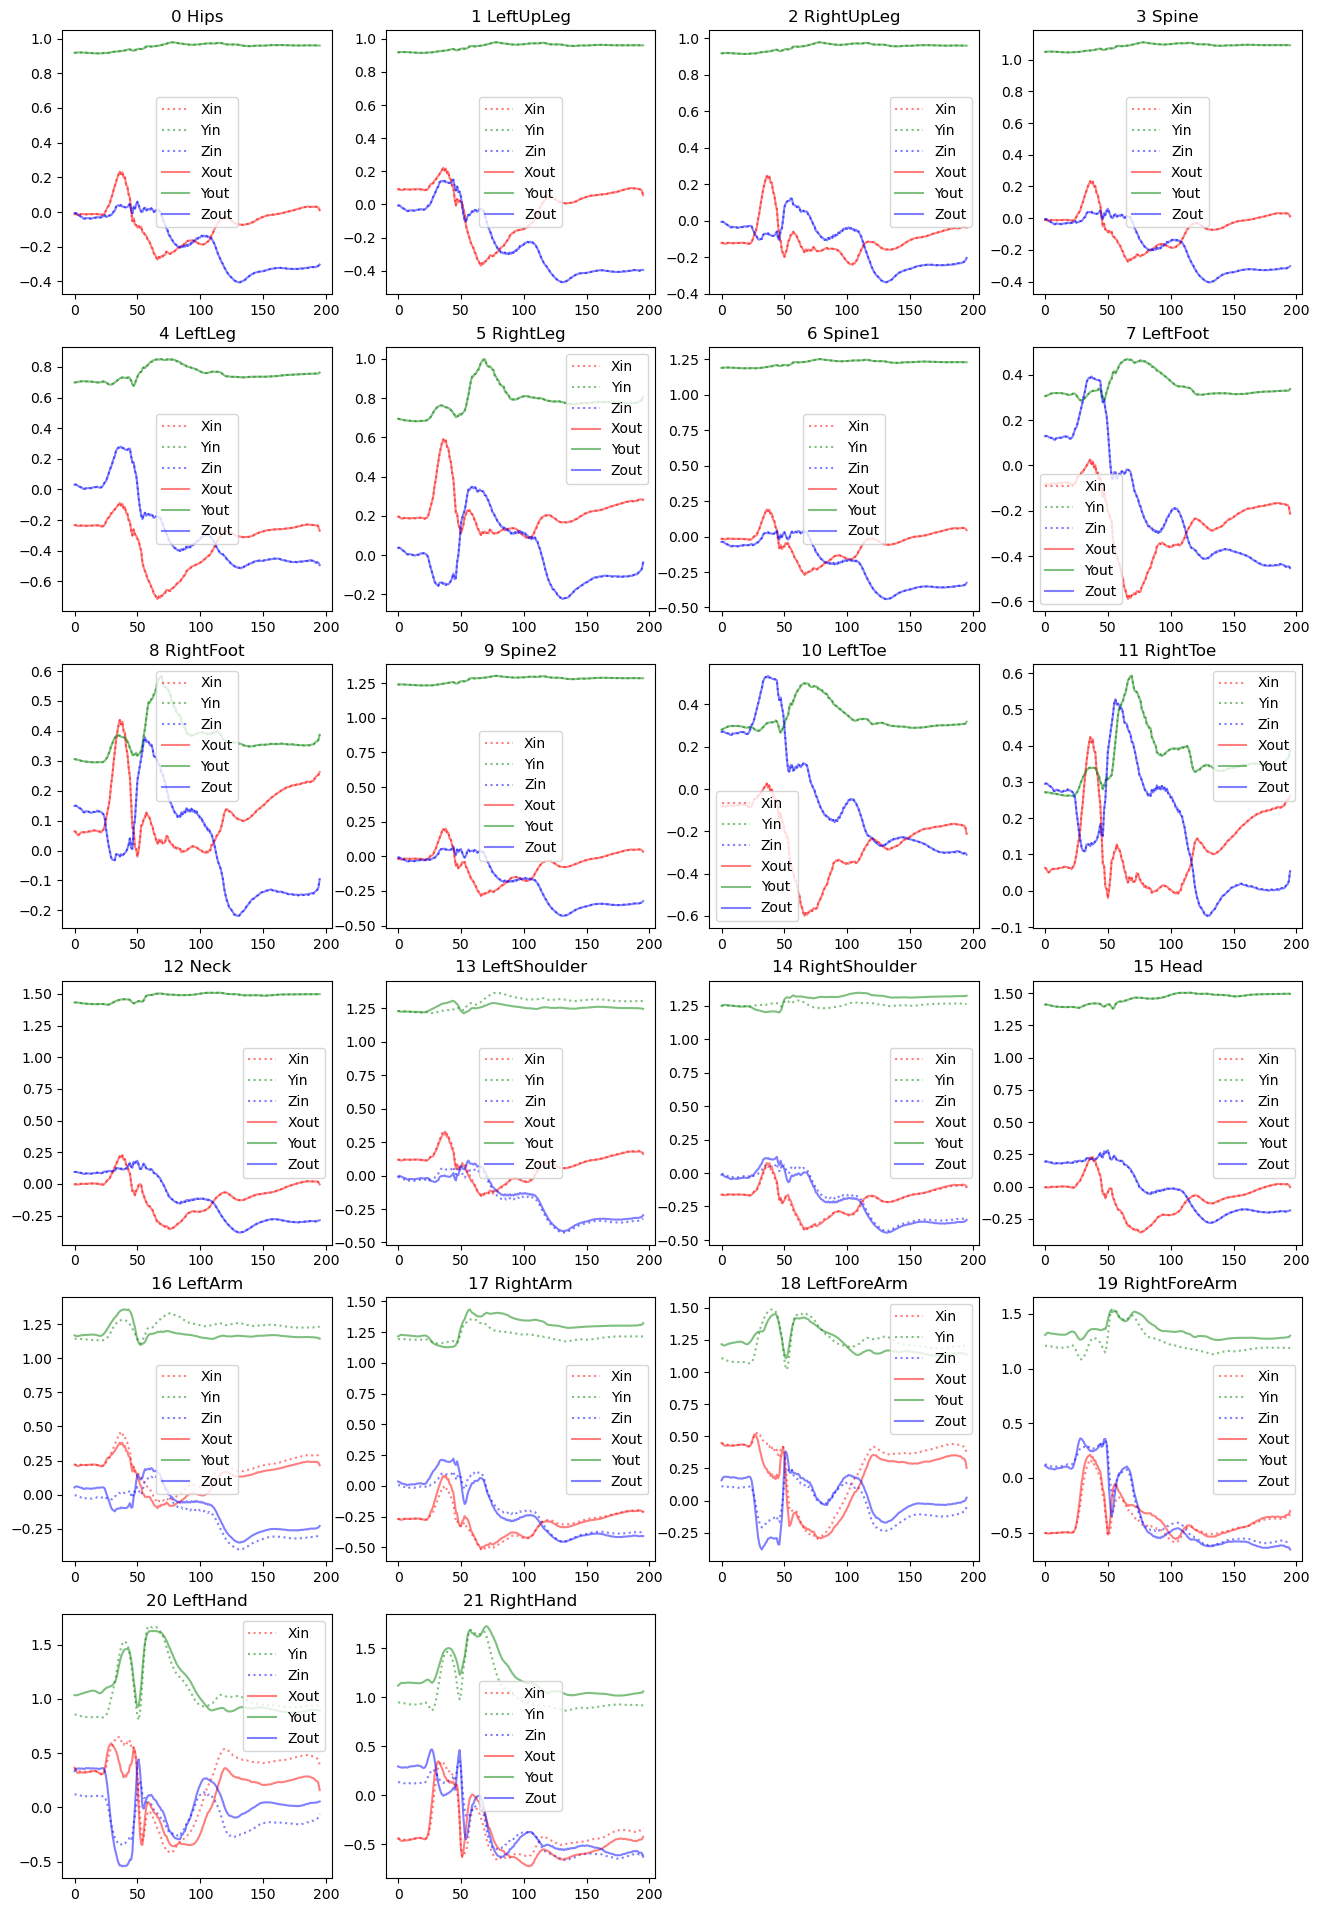

In [57]:
names_inv = [names[i] for i in [0, 1, 5, 9, 2, 6, 10, 3, 7, 11, 4, 8, 12, 14, 18, 13, 15, 19, 16, 20, 17, 21]]

fig = plt.figure(figsize=(16, 24))

for j in range(22):
    plt.subplot(6, 4, j+1)
    plt.title(f"{j} {names_inv[j]}")
    plt.plot(pos_in[:, j, 0], c="red", linestyle=":", label="Xin", alpha=0.5)
    plt.plot(pos_in[:, j, 1], c="green", linestyle=":", label="Yin", alpha=0.5)
    plt.plot(pos_in[:, j, 2], c="blue", linestyle=":", label="Zin", alpha=0.5)
    plt.plot(pos_out[:, j, 0], c="red", linestyle="-", label="Xout", alpha=0.5)
    plt.plot(pos_out[:, j, 1], c="green", linestyle="-", label="Yout", alpha=0.5)
    plt.plot(pos_out[:, j, 2], c="blue", linestyle="-", label="Zout", alpha=0.5)
    plt.legend()

plt.show()


In [58]:
names

['Hips',
 'LeftUpLeg',
 'LeftLeg',
 'LeftFoot',
 'LeftToe',
 'RightUpLeg',
 'RightLeg',
 'RightFoot',
 'RightToe',
 'Spine',
 'Spine1',
 'Spine2',
 'Neck',
 'Head',
 'LeftShoulder',
 'LeftArm',
 'LeftForeArm',
 'LeftHand',
 'RightShoulder',
 'RightArm',
 'RightForeArm',
 'RightHand']